In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

data_path = '/kaggle/input/store-sales-time-series-forecasting/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates=['date'])

# holidays_events = pd.read_csv(os.path.join(data_path, 'holidays_events.csv'), parse_dates=['date'])
oil = pd.read_csv(os.path.join(data_path, 'oil.csv'), parse_dates=['date'])
stores = pd.read_csv(os.path.join(data_path, 'stores.csv'))
transactions = pd.read_csv(os.path.join(data_path, 'transactions.csv'), parse_dates=['date'])
submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), index_col='id')

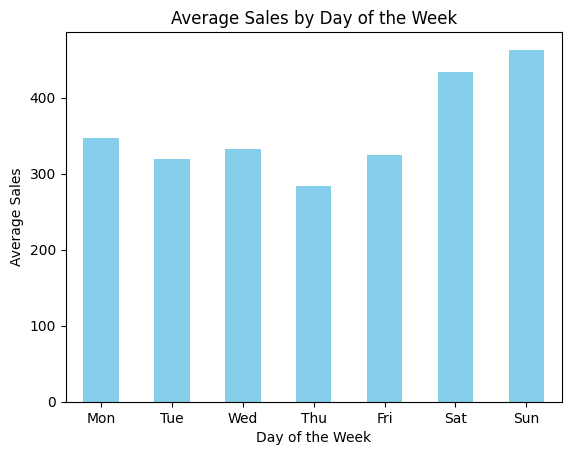

F-statistic: 1506.5585637191425
P-value: 0.0


In [2]:

data_path = '/kaggle/input/store-sales-time-series-forecasting/'

data = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])

data['dayofweek'] = data['date'].dt.dayofweek

average_sales = data.groupby('dayofweek')['sales'].mean()


average_sales.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


grouped = data.groupby('dayofweek')['sales']

sales_data = [group for name, group in grouped]

f_stat, p_value = f_oneway(*sales_data)
print('F-statistic:', f_stat)
print('P-value:', p_value)

In [4]:

oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].rolling(window=5, min_periods=1, center=True).mean())

oil['dcoilwtico'].fillna(oil['dcoilwtico'].mean(), inplace=True)
oil['date'] = pd.to_datetime(oil['date'])


train_data = train.copy().drop(['onpromotion'], axis=1)
test_data = test.copy().drop(['onpromotion'], axis=1)


train_data['dayofweek'] = data['date'].dt.dayofweek
test_data['dayofweek'] = data['date'].dt.dayofweek


train_data = train_data.merge(oil, on='date', how='left')
test_data = test_data.merge(oil, on='date', how='left')


ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])


num_days_train = train["date"].nunique()
num_stores_train = train["store_nbr"].nunique()
num_families_train = train["family"].nunique()

num_days_test = test["date"].nunique()
num_stores_test = test["store_nbr"].nunique()
num_families_test = test["family"].nunique()


pivoted_train = train_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='sales')

train_samples = int(num_days_train * 0.95)
train_samples_df = pivoted_train[:train_samples]
valid_samples_df = pivoted_train[train_samples:]



print("\nFirst 5 rows of the original train data:")
print(train_samples_df.shape)
print(train_samples_df.head())


minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_samples_df)
scaled_train_samples = minmax_scaler.transform(train_samples_df)
scaled_validation_samples = minmax_scaler.transform(valid_samples_df)

print("\nFirst 5 rows of the original train data:")
print(scaled_train_samples.shape)
print(scaled_train_samples)


First 5 rows of the original train data:
(1599, 1782)
store_nbr                          1                                       \
family                            0    1    2       3    4        5    6    
date       dcoilwtico dayofweek                                             
2013-01-01 93.055     1          0.0  0.0  0.0     0.0  0.0    0.000  0.0   
2013-01-02 93.140     2          2.0  0.0  2.0  1091.0  0.0  470.652  0.0   
2013-01-03 92.970     3          3.0  0.0  0.0   919.0  0.0  310.655  0.0   
2013-01-04 93.120     4          3.0  0.0  3.0   953.0  0.0  198.366  0.0   
2013-01-05 NaN        5          5.0  0.0  3.0  1160.0  0.0  301.057  0.0   

store_nbr                                                ...    9           \
family                               7      8        9   ...   23       24   
date       dcoilwtico dayofweek                          ...                 
2013-01-01 93.055     1             0.0    0.0    0.000  ...  0.0    0.000   
2013-01-02 93.14

In [5]:

def split_series(series, n_past, n_future):
    X, y = [], []
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        X.append(series[window_start:past_end, :])
        y.append(series[past_end:future_end, :])
    return np.array(X), np.array(y)


n_past = 16
n_future = 16
n_features = num_stores_train * num_families_train


X_train, y_train = split_series(scaled_train_samples, n_past, n_future)
X_val, y_val = split_series(scaled_validation_samples, n_past, n_future)


model = Sequential()
model.add(layers.LSTM(units=200, return_sequences=True, input_shape=(n_past, n_features)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(n_features)))


model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])


model.summary()


early_stopping = EarlyStopping(monitor='val_mae', min_delta=0.0001, patience=100, restore_best_weights=True)


EPOCHS = 1000
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[early_stopping], batch_size=512, shuffle=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16, 200)        │     1,586,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 200)        │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16, 300)        │       601,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 16, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 16, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 1782)       │       536,382 │
│ (TimeDistributed)               │                        │             

 Total params: 6,337,982 (24.18 MB)

 Trainable params: 6,333,982 (24.16 MB)

 Non-trainable params: 4,000 (15.62 KB)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - loss: 0.4717 - mae: 0.4717 - val_loss: 0.2281 - val_mae: 0.2281
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.3228 - mae: 0.3228 - val_loss: 0.2286 - val_mae: 0.2286
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.2826 - mae: 0.2826 - val_loss: 0.2267 - val_mae: 0.2267
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.2581 - mae: 0.2581 - val_loss: 0.2343 - val_mae: 0.2343
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.2395 - mae: 0.2395 - val_loss: 0.2385 - val_mae: 0.2385
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.2244 - mae: 0.2244 - val_loss: 0.2236 - val_mae: 0.2236
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.2197 - mae: 0.2197 - val_loss: 0.2323 - val_mae: 0.2323
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.2081 - mae: 0.2081 - val_loss: 0.2170 - val_mae: 0.2170
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - l

In [6]:

x_test_pred = scaled_validation_samples[-n_past:].reshape((1, n_past, n_features))
scaled_y_predict = model.predict(x_test_pred)


y_predict = pd.DataFrame(minmax_scaler.inverse_transform(scaled_y_predict.reshape((n_future, n_features))), columns=valid_samples_df.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


In [7]:

pivoted_test = test_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='id')

for day_ith, day_ith_pred in y_predict.iterrows():
    for n_samples_per_day in range(len(day_ith_pred)):
        sample_id = pivoted_test.iloc[[day_ith], [n_samples_per_day]].values[0][0]
        values = max(0, day_ith_pred.values[n_samples_per_day])
        submission.at[sample_id, 'sales'] = max(0, day_ith_pred.values[n_samples_per_day])

submission.to_csv('submission.csv')

print("\nFirst 5 rows of the data:")
print(submission.head())



First 5 rows of the data:
               sales
id                  
3000888     3.804556
3000889     0.000972
3000890     2.939100
3000891  2513.799072
3000892     0.142520
